# Rete Neurale: Classificazione di fiori

Questo notebook descriverà passo passo ciò che si fa per allenare una vera e propria rete neurale (per quanto semplice). Rispetto al primo esempio, non faremo l'assunzione di dipendenza lineare e, di conseguenza, dovremo usare un approccio più generale.

Prima di tutto, descrivo qual è il problema che cerchiamo di risolvere.

## Iris Dataset

Iris è un tipo di fiore e, in base alla lunghezza del petalo e del sepalo, si può classificare in tre sottospecie. Di seguito uso Pillow e Matplotlib per visualizzare un esempio di ciascuna "classe".

In [23]:
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

`os` è un pacchetto che serve ad astrarre operazioni dei sistemi operativi. Per esempio su sistemi non Windows, come anche in tutti i principali linguaggi di programmazione, un percorso di un file in una cartella si scrive come `cartella/file`, mentre Windows usa `cartella\\file` (La doppia sbarra serve perché in una stringa '\\' è un carattere speciale). Usando `os` deleghiamo la gestione di operazioni specifiche a Python, e non ce ne preoccupiamo.

All'interno di questa cartella (`RetiNeurali`) ci sono una cartella `dati`, che contiene dati per i nostri problemi, e una cartella `immagini`, che contiene, be', immagini. Dunque, per aprire:

In [9]:
percorso_immagini = os.path.join('immagini') # Equivale a .\\immagini su Windows, ./immagini su Unix.
nomi_immagini = os.listdir(percorso_immagini) # listdir crea una lista con l'elenco dei file in percorso_immagini
print(nomi_immagini)

['Iris Virginica.jpg', 'Iris Setosa.jpg', 'Iris Versicolor.jpg']


In [12]:
# Ora leggiamo le immagini
virginica = Image.open(os.path.join(percorso_immagini, nomi_immagini[0]))
setosa = Image.open(os.path.join(percorso_immagini, nomi_immagini[1]))
versicolor = Image.open(os.path.join(percorso_immagini, nomi_immagini[2]))

Text(0.5, 1.0, 'Iris Versicolor')

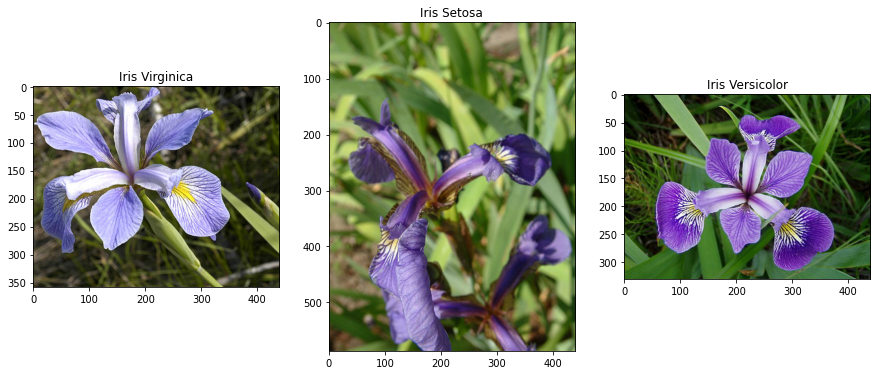

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(virginica)
ax[0].set_title('Iris Virginica')
ax[1].imshow(setosa)
ax[1].set_title('Iris Setosa')
ax[2].imshow(versicolor)
ax[2].set_title('Iris Versicolor')


La specie può essere determinata misurando 4 quantità: lunghezza del sepalo, larghezza del sepalo, lunghezza del petalo e larghezza del petalo. Per fortuna qualcuno, nel 1936, ha preso le misure di 150 fiori, e i dati sono disponibili per tutti. Infatti, nella cartella `dati`, c'è un file .csv (Comma separated value), che non è altro che una lista di numeri divisi da una virgola. La prima riga può (opzionale) contenere nomi delle varie colonne. Ogni riga successiva alla prima contiene esattamente lo stesso numero di valori.  
Potremmo usare le solite funzionlità di lettura dei file di Python, ma il pacchetto `pandas` aiuta con questo tipo di file, oltre a facilitare visualizzazione ed alcune operazioni.

In [32]:
import pandas as pd
iris = pd.read_csv(os.path.join('dati', 'iris.csv'))
iris.head() # Il metodo head() visualizza le prime n righe, default 5

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


La terza colonna in particolare definisce la classe della varietà. Cerchiamo di estrarre tutti i possibili valori.

In [34]:
varieta = iris['variety']
varieta

0         Setosa
1         Setosa
2         Setosa
3         Setosa
4         Setosa
         ...    
145    Virginica
146    Virginica
147    Virginica
148    Virginica
149    Virginica
Name: variety, Length: 150, dtype: object

È una lista con valori ripetuti meglio passarla a un `set` (insieme).

In [36]:
varieta = set(varieta)
varieta

{'Setosa', 'Versicolor', 'Virginica'}

Come vedi, un `set` non contiene mai duplicati, in linea con la definizione di insieme nel senso matematico. Quindi aggiungendo un elemento che esiste già non succede niente. Nota anche le parentesi graffe (come un dizionario, ma senza coppie di valori chiave: valore)

A questo punto cerchiamo di analizzare graficamente se c'è una relazione ovvia fra le quantità. Essendo le variabili 4, le rappresento a due a due.

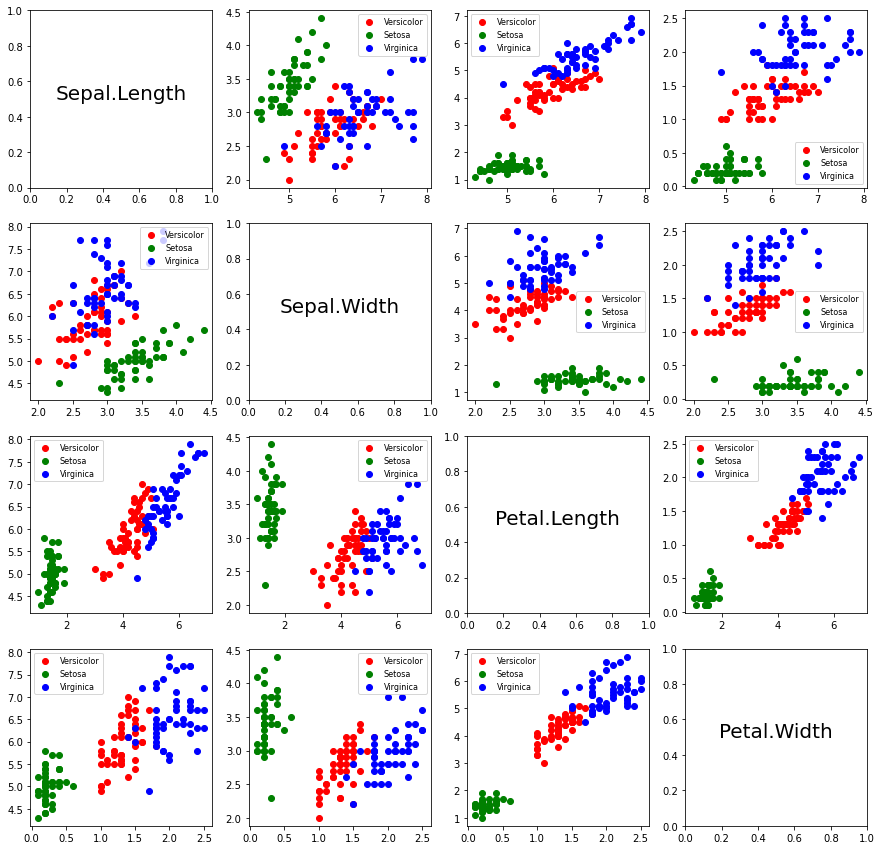

In [67]:
titoli = iris.keys()[:-1] # keys dà la riga con i nomi delle colonne; variety non ci serve al momento.
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
colori = ['red','green','blue']
for riga, titolo in enumerate(titoli):
    for colonna, titolo_2 in enumerate(titoli):
        if titolo == titolo_2:
            ax[riga][colonna].text(0.5, 0.5, titolo.title(), horizontalalignment='center', fontsize=20)
        else:
            for colore, var in zip(colori, varieta):
                specie = iris[iris['variety']==var]
                ax[riga][colonna].scatter(specie[titolo], specie[titolo_2], color=colore, label=var)
            ax[riga][colonna].legend(fontsize=8)

Una relazione c'è ma non sembra esserci una legge lineare e in alcuni casi i dati non sembrano molto separabili. Cerchiamo dunque una relazione generica (non lineare), in forma di rete neurale.

### Rete Neurale